<a href="https://colab.research.google.com/github/alilotfi90/Flower_Classification/blob/main/flower-classification-data-augmentation-random-flip-rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

!pip install efficientnet_pytorch
from zipfile import ZipFile
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import zipfile
from PIL import Image
import os

drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=daa274eef8a5aedfca18fdc7153b57b2d0521dd2ed80900c0cde94c947c46bb2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Mounted at /content/drive


In [2]:
with zipfile.ZipFile('/content/drive/MyDrive/flowerimages.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped_images_flower')

In [3]:
!pip install Pillow
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
unzipped_folder = '/content/unzipped_images_flower/flowers'
output_folder = '/content/resized_images_flower'


os.makedirs(output_folder, exist_ok=True)

subdirectories = [d for d in os.listdir(unzipped_folder) if os.path.isdir(os.path.join(unzipped_folder, d))]

# seen = set()
for flower_category in subdirectories:
    input_folder = os.path.join(unzipped_folder, flower_category)
    output_category_folder = os.path.join(output_folder, flower_category)


    os.makedirs(output_category_folder, exist_ok=True)

    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

    for image_file in image_files:
        input_image_path = os.path.join(input_folder, image_file)
        output_image_path = os.path.join(output_category_folder, image_file)

        image = Image.open(input_image_path)

        # # Resize the image
        # target_size = (456, 456)
        # image = image.resize(target_size, Image.ANTIALIAS)

        # Convert the image to grayscale
        image = image.convert('L')


        image.save(output_image_path)

        # width, height = image.size
        # # seen.add((width, height))

In [5]:
data = []

for flower_category in subdirectories:
    category_folder = os.path.join(output_folder, flower_category)
    image_files = [f for f in os.listdir(category_folder) if f.endswith('.jpg')]
    label = subdirectories.index(flower_category)  # Assign a label based on the folder name

    # # Limit the number of images to max_images_per_class
    # image_files = image_files[:max_images_per_class]

    for image_file in image_files:
        image_path = os.path.join(category_folder, image_file)
        data.append((image_path, label))

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# Splitting train_data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

Loaded pretrained weights for efficientnet-b0
Epoch 1/5
Training Loss: 0.783, Accuracy: 76.34%
Validation Loss: 0.886, Accuracy: 75.70%
Epoch 2/5
Training Loss: 0.772, Accuracy: 76.34%
Validation Loss: 0.628, Accuracy: 82.29%
Epoch 3/5
Training Loss: 0.478, Accuracy: 85.36%
Validation Loss: 0.578, Accuracy: 81.82%
Epoch 4/5
Training Loss: 0.387, Accuracy: 87.91%
Validation Loss: 0.609, Accuracy: 81.02%
Epoch 5/5
Training Loss: 0.375, Accuracy: 88.58%
Validation Loss: 0.557, Accuracy: 83.76%
Epoch 1/10
Training Loss: 0.256, Accuracy: 92.44%
Validation Loss: 0.355, Accuracy: 89.72%
Epoch 2/10
Training Loss: 0.337, Accuracy: 89.73%
Validation Loss: 0.577, Accuracy: 84.16%
Epoch 3/10
Training Loss: 0.284, Accuracy: 90.99%
Validation Loss: 0.504, Accuracy: 87.38%
Epoch 4/10
Training Loss: 0.245, Accuracy: 92.31%
Validation Loss: 0.467, Accuracy: 87.06%
Epoch 5/10
Training Loss: 0.230, Accuracy: 92.89%
Validation Loss: 0.644, Accuracy: 82.14%
Epoch 6/10
Training Loss: 0.211, Accuracy: 93.55%

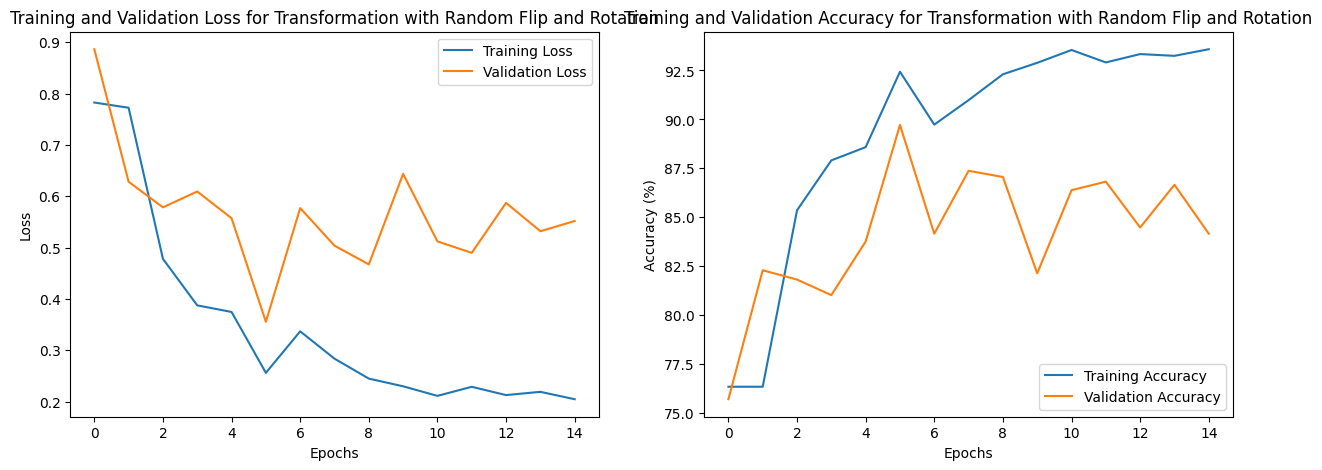

In [10]:
from sklearn.metrics import accuracy_score

transform_2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label



# Creating datasets for training, validation, and testing
train_dataset = CustomDataset(train_data, transform=transform_2)
val_dataset = CustomDataset(val_data, transform=transform_2)
test_dataset = CustomDataset(test_data, transform=transform_2)

# Creating data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



# model, criterion, optimizer
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=16)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

max_epoch = [5, 10]
for e in max_epoch:
    model.train()
    for epoch in range(e):
        print(f"Epoch {epoch + 1}/{e}")
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        print(f'Training Loss: {avg_train_loss:.3f}, Accuracy: {train_accuracy:.2f}%')

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Validation Loss: {avg_val_loss:.3f}, Accuracy: {val_accuracy:.2f}%')


model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {avg_test_loss:.3f}, Accuracy: {test_accuracy:.2f}%')

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss for Transformation with Random Flip and Rotation')  # Corrected title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Transformation with Random Flip and Rotation')  # Appropriate title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

save_path = '/content/drive/MyDrive/effnet_flip_rotation_plot.jpg'

plt.savefig(save_path)

plt.show()

In [12]:
model_save_path = '/content/drive/MyDrive/efficientnet_model_random_flip_rotation.pth'
torch.save(model.state_dict(), model_save_path)